# **Artificial Neural Networks and Deep Learning**

---

## ⚙️ **Libraries Import**

In [ ]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu128
Device: cpu


## ⏳ **Data Loading**

In [131]:
DATASET_ROOT = Path("./dataset")

# --- 2️⃣ Kaggle ---
# DATASET_ROOT = Path("/kaggle/input/pirate-pain")

# --- 3️⃣ Server o cluster privato (es. Westworld/Elysium) ---
# DATASET_ROOT = Path("/multiverse/datasets/private_dataset/pirate_pain")


In [132]:
import pandas as pd

# Caricamento dati
X_train = pd.read_csv(DATASET_ROOT / "pirate_pain_train.csv")
y_train = pd.read_csv(DATASET_ROOT / "pirate_pain_train_labels.csv")
X_test  = pd.read_csv(DATASET_ROOT / "pirate_pain_test.csv")

print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test:  {X_test.shape}")

  X_train: (105760, 40)
  y_train: (661, 2)
  X_test:  (211840, 40)


## 🔎 **Exploration and Data Analysis**

In [114]:
# Controllo struttura e tipi
display(X_train.head())
X_train.info()


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [133]:
# MERGE BETWEEN TRAIN DATA AND LABELS
# the labels are in a separated file linked through 'sample_index
# here we merge X_train and y_train in a unique Dataframe to explore

train_merge = X_train.merge(y_train, on="sample_index", how="left")

# check whether all the labels have been associated or not
missing_labels = train_merge["label"].isna().sum()
if missing_labels > 0:
    print(f"{missing_labels} rows without a label")

# check
print(train_merge[["sample_index","time","label"]].head())
print("Class Distribution")
print(train_merge["label"].value_counts())

   sample_index  time    label
0             0     0  no_pain
1             0     1  no_pain
2             0     2  no_pain
3             0     3  no_pain
4             0     4  no_pain
Class Distribution
label
no_pain      81760
low_pain     15040
high_pain     8960
Name: count, dtype: int64


In [116]:
print(y_train["label"].value_counts())

label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64


## 🔄 **Data Preprocessing**

In [134]:
def dataset_conversion_type(df, label_conversion=False):
    df = df.copy()

    # select all columns starting with joint_
    joint_cols = [col for col in df.columns if col.startswith("joint_")]

    # convert all joint columns in float32
    df[joint_cols] = df[joint_cols].astype(np.float32)

    # select all columns starting with pain_survey_
    pain_survey_cols = [col for col in df.columns if col.startswith("pain_survey_")]
    df[pain_survey_cols] = df[pain_survey_cols].astype(np.int8)

    legs_map = {"two": 0, "one+peg_leg": 1}
    hands_map = {"two": 0, "one+hook_hand": 1}
    eyes_map  = {"two": 0, "one+eye_patch": 1}

    df["n_legs"]  = df["n_legs"].map(legs_map).astype(np.int8)
    df["n_hands"] = df["n_hands"].map(hands_map).astype(np.int8)
    df["n_eyes"]  = df["n_eyes"].map(eyes_map).astype(np.int8)

    return df

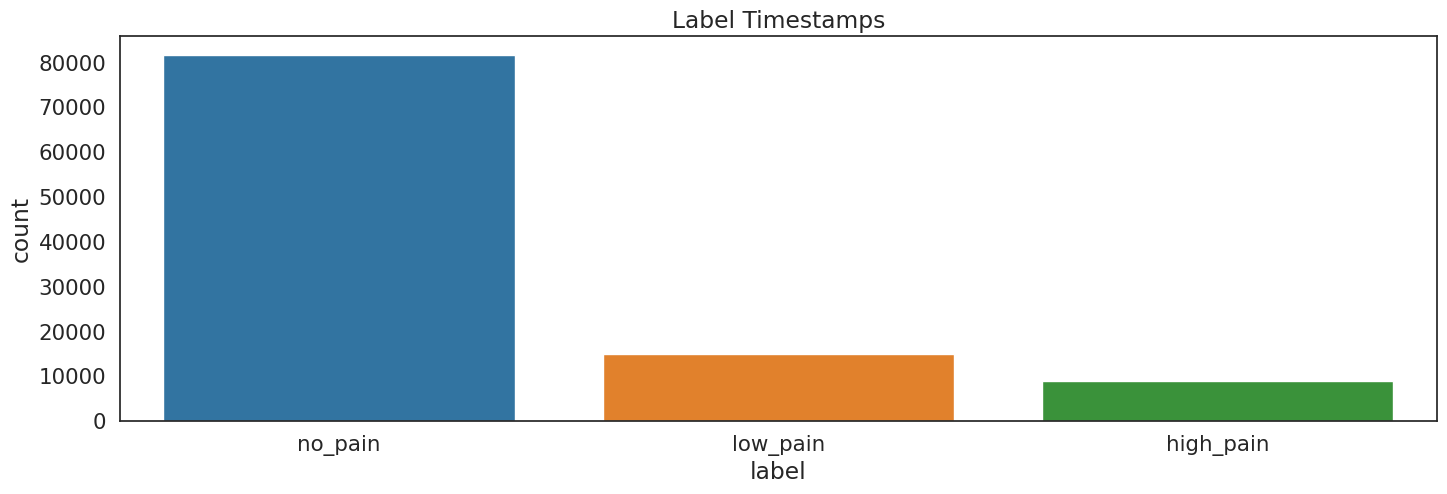

In [53]:
# Visualise the count of timestamps for each kind of pain
plt.figure(figsize=(17, 5))
sns.countplot(
    x='label',
    data=train_merge,
    order=train_merge['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Label Timestamps')

# Display the plot
plt.show()

count    661.0
mean     160.0
std        0.0
min      160.0
25%      160.0
50%      160.0
75%      160.0
max      160.0
dtype: float64


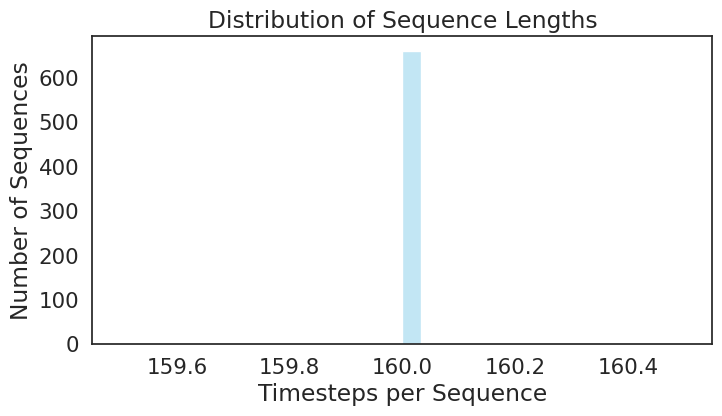

In [118]:
# Count the number of timesteps per sample
seq_lengths = train_merge.groupby("sample_index").size()

# Quick look
print(seq_lengths.describe())

plt.figure(figsize=(8,4))
sns.histplot(seq_lengths, bins=30, kde=True, color="skyblue")
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Timesteps per Sequence")
plt.ylabel("Number of Sequences")
plt.show()


In [135]:
# Define a function to inspect sensor data for a specific pain
def inspect_pain(pain, df, n_rows=500):
    # Filter the DataFrame for the specified pain and limit to 500 rows
    joint_cols = [col for col in df.columns if col.startswith("joint_")]
    data = df[df['label'] == pain][joint_cols][:n_rows]

    # Dynamically adjust figure height based on number of joints
    fig_height = len(joint_cols) * 1  # keep proportions similar to your original
    axis = data.plot(subplots=True, figsize=(17, fig_height), title=pain)

    # Adjust legend position for each subplot
    for ax in axis:
        ax.legend(loc='lower right')


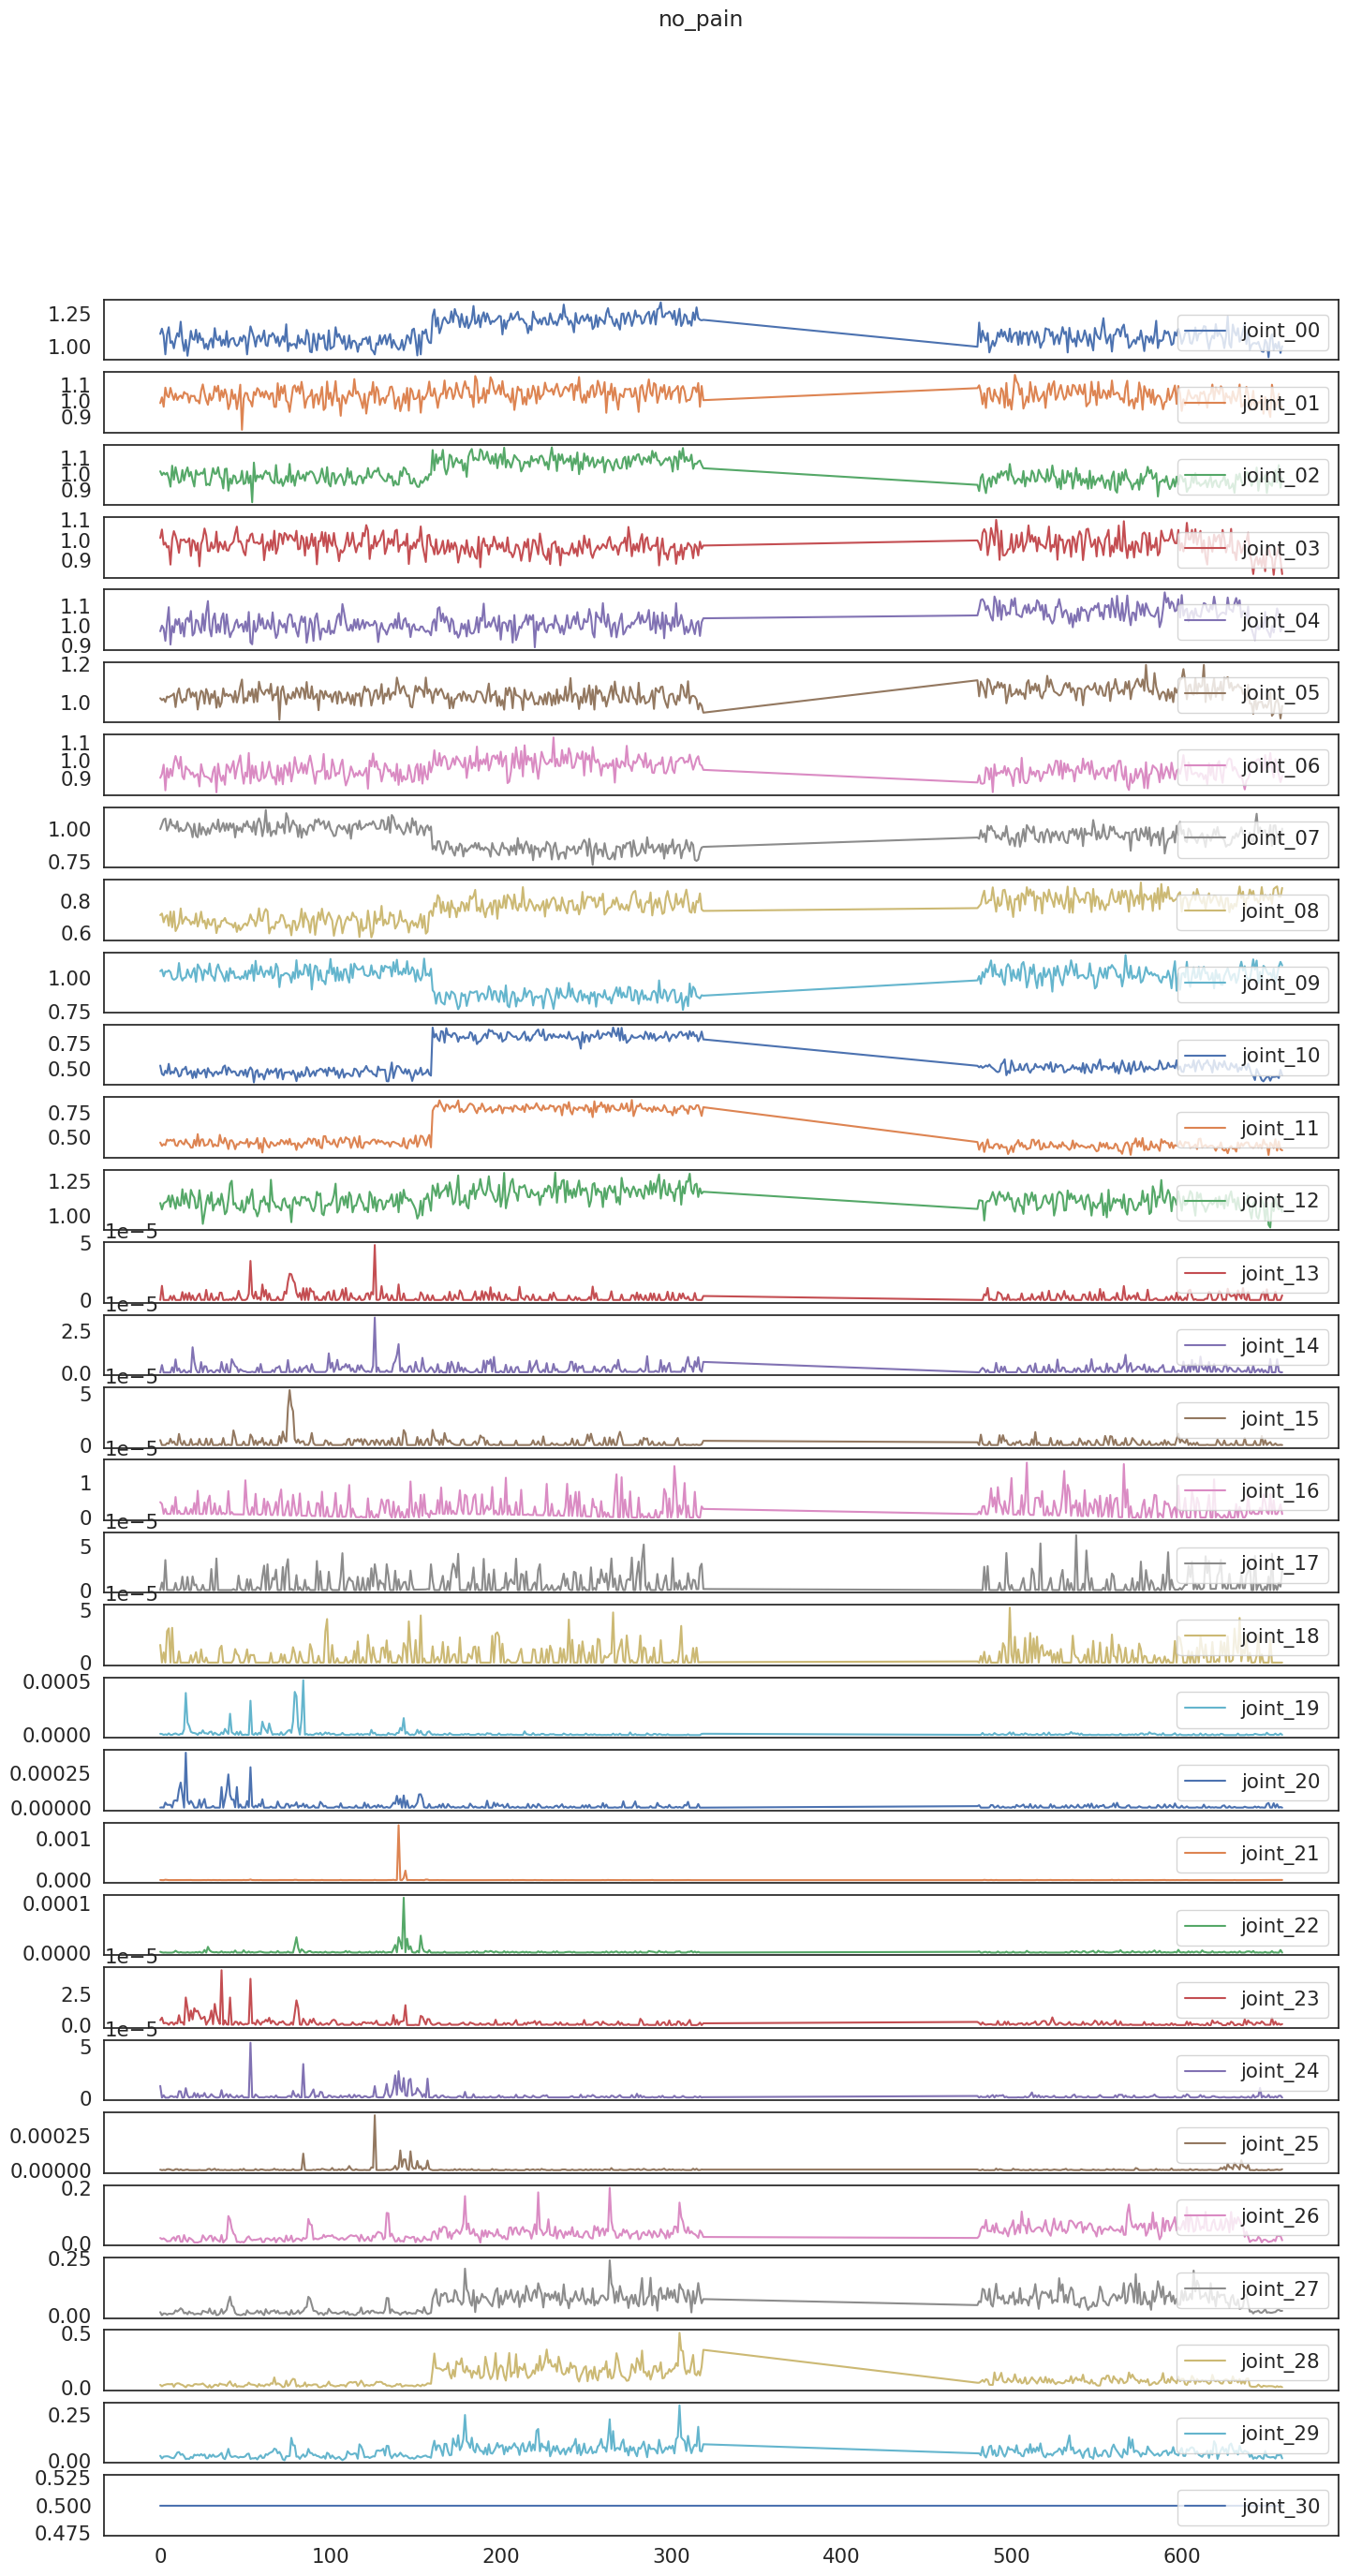

In [120]:
# Inspect the sensor data for the activity "Standing"
inspect_pain("no_pain", train_merge)

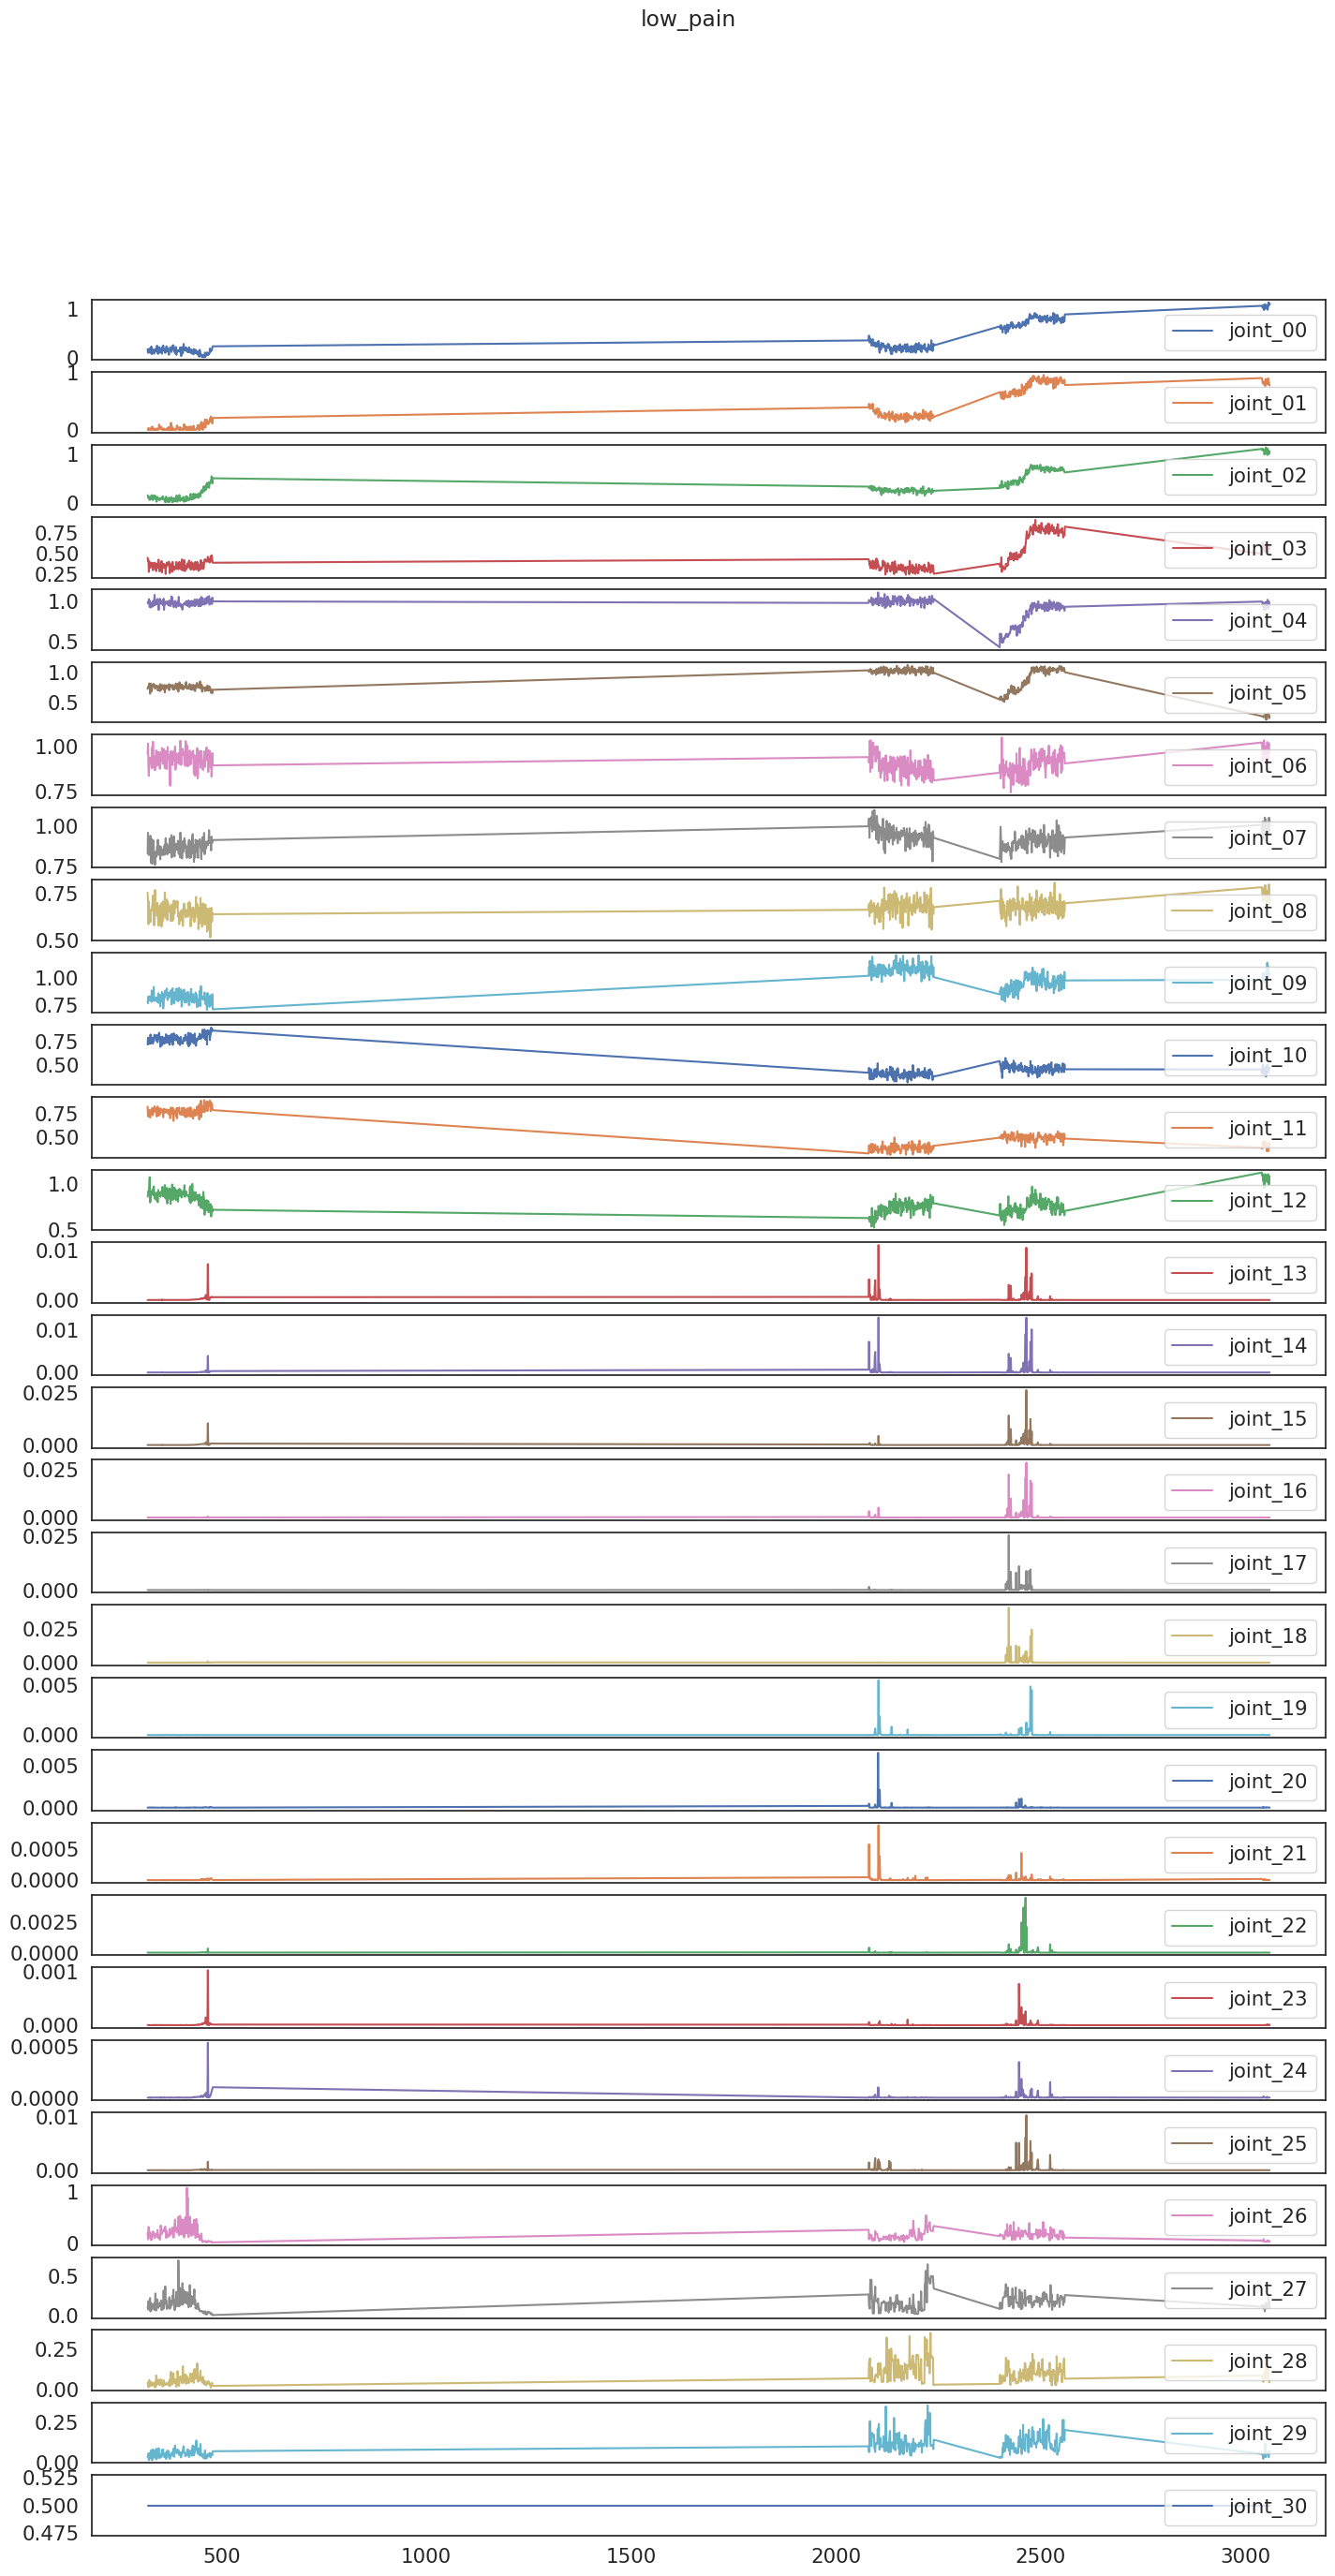

In [121]:
# Inspect the sensor data for the activity "Standing"
inspect_pain("low_pain", train_merge)

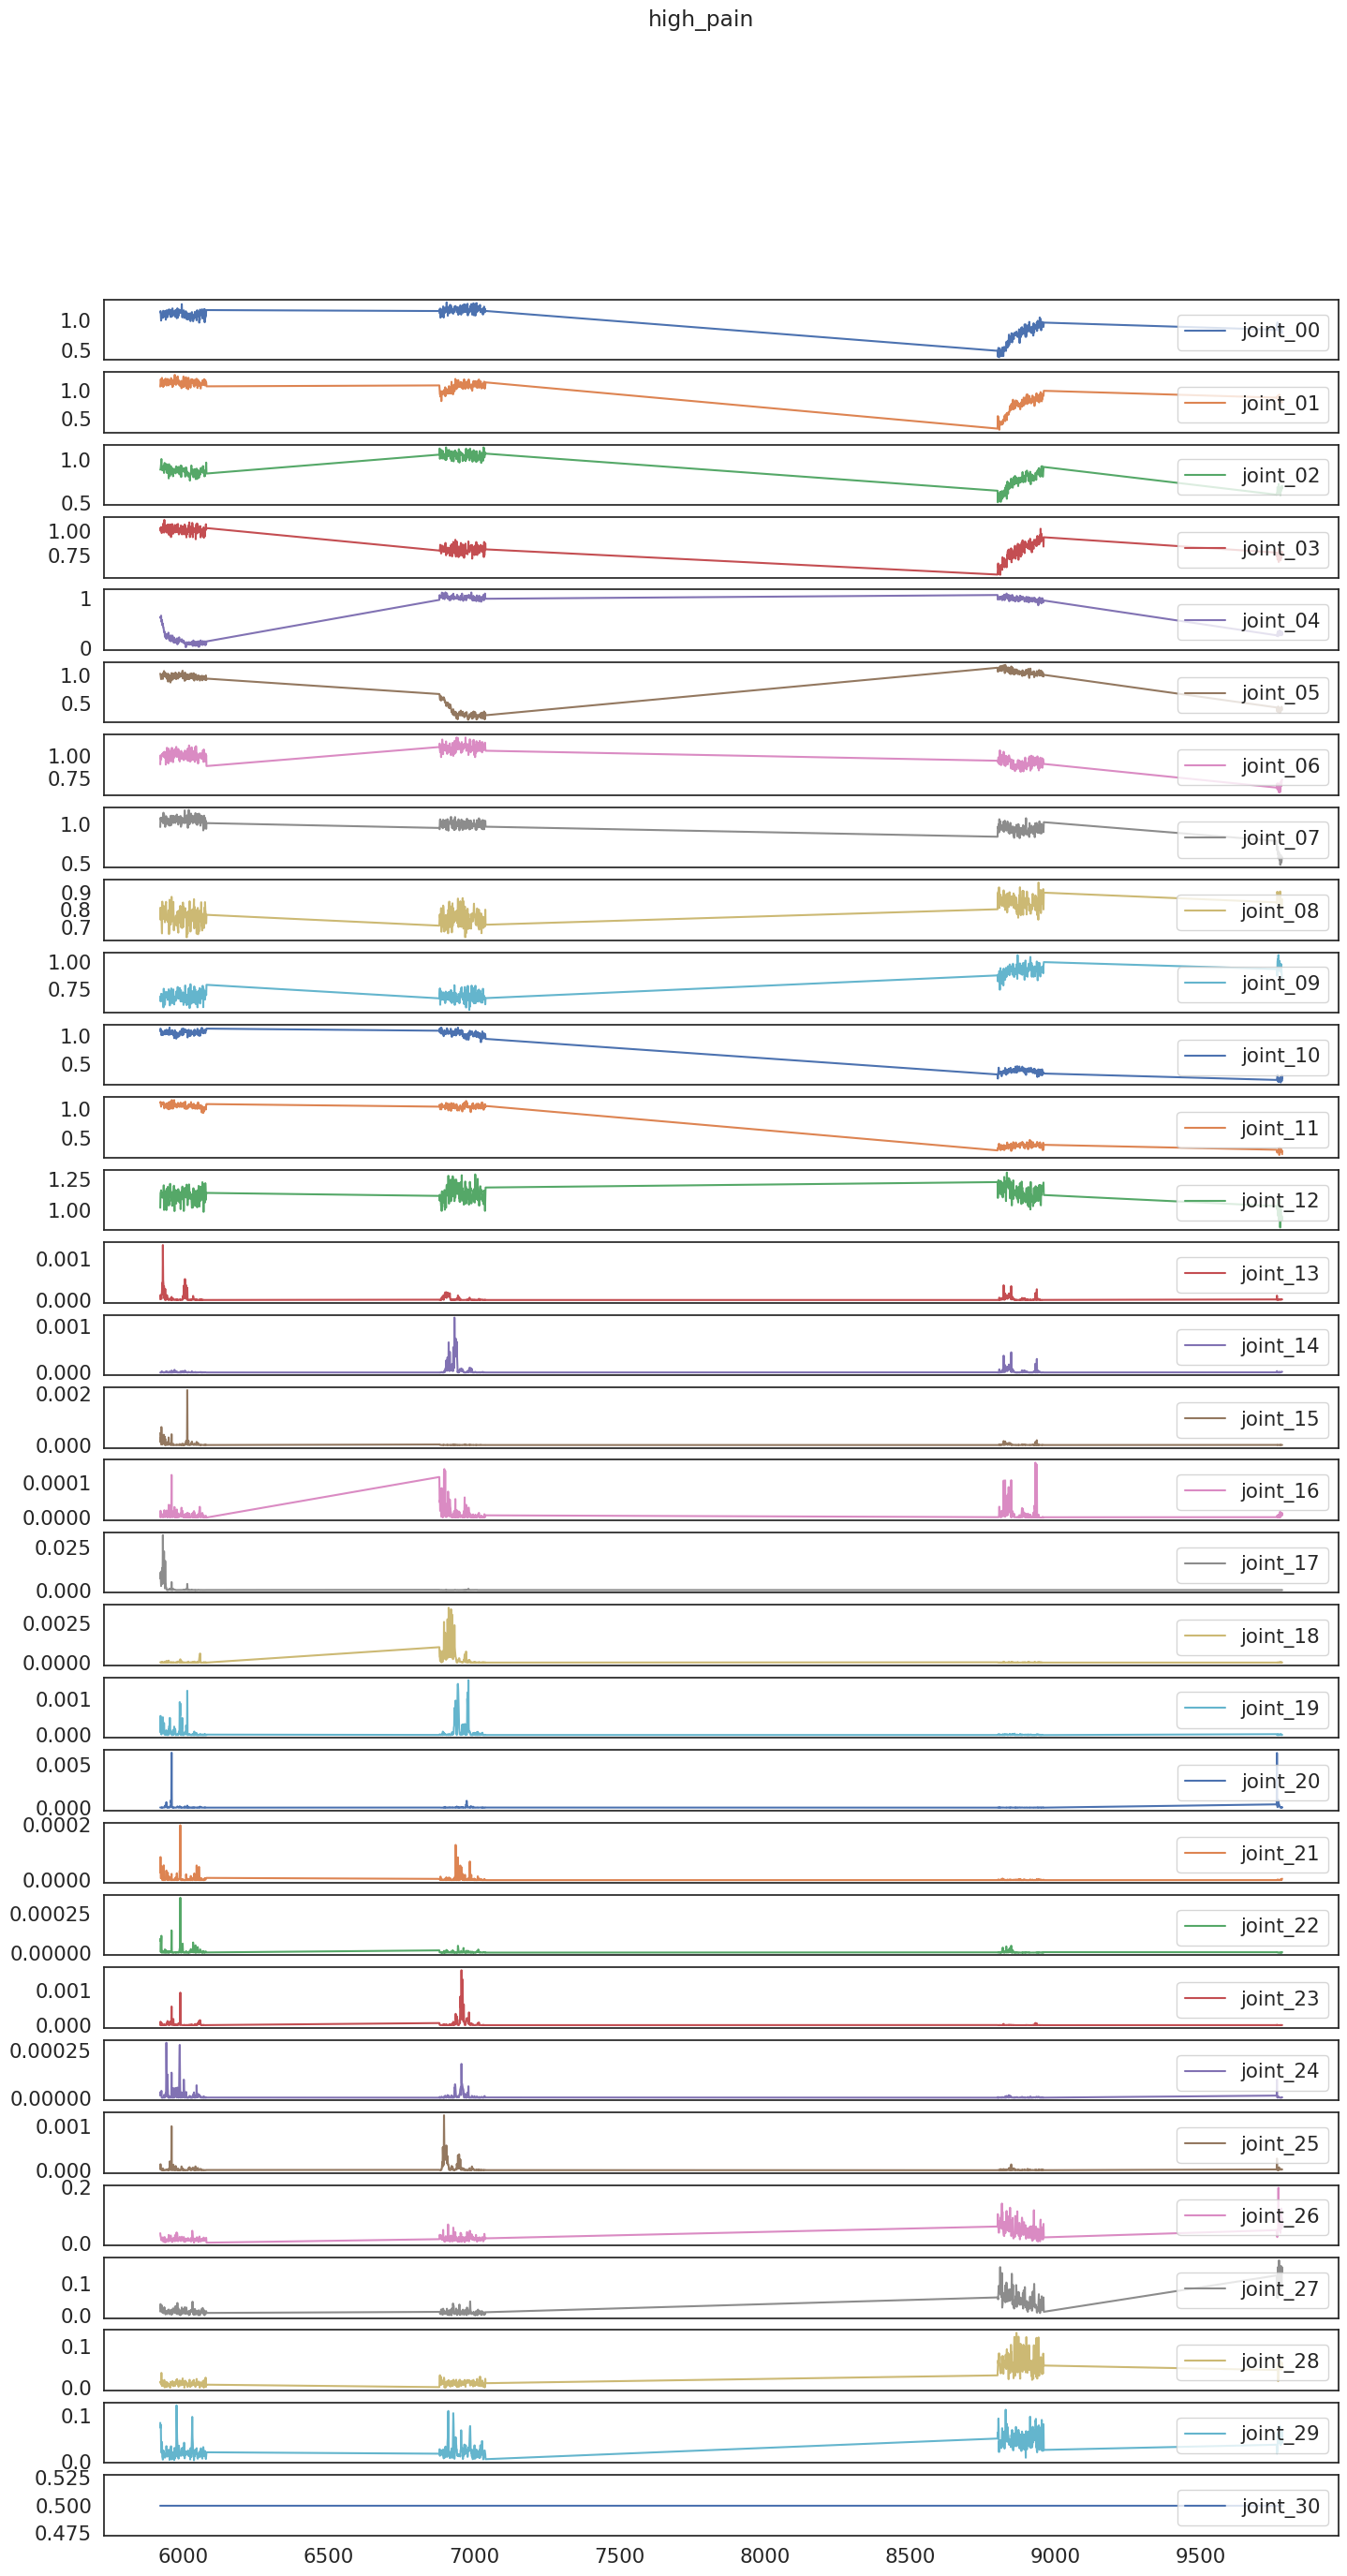

In [122]:
# Inspect the sensor data for the activity "Standing"
inspect_pain("high_pain", train_merge)

In [136]:
def preprocess_joints(df, 
                      drop_redundant=False, 
                      drop_near_zero=False, 
                      drop_low_var=False,
                      verbose=True):
    """
    Simplify joint_* preprocessing based on EDA results.
    Removes constant, redundant, or near-zero-variance joints.

    Returns a (df_out, feature_cols) tuple.
    """
    joint_cols = sorted([c for c in df.columns if c.startswith("joint_")],
                        key=lambda x: int(x.split("_")[1]))
    drop = set()

    # 1 Drop constant joint_30
    if "joint_30" in joint_cols:
        drop.add("joint_30")

    #  Drop redundant joints (from correlation heatmap)
    if drop_redundant:
        for c in ["joint_01", "joint_02", "joint_05"]:
            if c in joint_cols:
                drop.add(c)

    # Drop near-zero variance joints (joint_13–25)
    if drop_near_zero:
        for i in range(13, 26):
            c = f"joint_{i:02d}"
            if c in joint_cols:
                drop.add(c)

    # (Optional) Drop low-variance but not-zero joints (joint_26–29)
    if drop_low_var:
        for i in range(26, 30):
            c = f"joint_{i:02d}"
            if c in joint_cols:
                drop.add(c)

    # apply
    kept = [c for c in joint_cols if c not in drop]
    df_out = df.drop(columns=list(drop), errors="ignore")

    if verbose:
        print(f"[preprocess_joints] start={len(joint_cols)} | kept={len(kept)} | dropped={len(drop)}")
        if drop:
            print("  • dropped:", sorted(list(drop)))

    return df_out, kept


In [137]:
X_train, _ = preprocess_joints(X_train)
X_test, _ = preprocess_joints(X_test)


[preprocess_joints] start=31 | kept=30 | dropped=1
  • dropped: ['joint_30']
[preprocess_joints] start=31 | kept=30 | dropped=1
  • dropped: ['joint_30']


In [138]:
X_train

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
0,0,0,2,0,2,1,two,two,two,1.094705,...,6.140248e-07,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,3.805930e-06,0.017592,0.013508,0.026798,0.027815
1,0,1,2,2,2,2,two,two,two,1.135183,...,1.931978e-06,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000e+00,0.013352,0.000000,0.013377,0.013716
2,0,2,2,0,2,2,two,two,two,1.080745,...,5.730838e-07,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,2.513519e-06,0.016225,0.008110,0.024097,0.023105
3,0,3,2,2,2,2,two,two,two,0.938017,...,3.677486e-05,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000e+00,0.011832,0.007450,0.028613,0.024648
4,0,4,2,2,2,2,two,two,two,1.090185,...,2.037939e-05,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,7.044832e-06,0.005360,0.002532,0.033026,0.025328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105755,660,155,2,2,0,0,two,two,two,1.051738,...,0.000000e+00,0.000000e+00,3.586810e-07,2.929207e-09,3.722175e-07,9.919764e-07,0.007856,0.026876,0.173566,0.221921
105756,660,156,2,2,0,2,two,two,two,1.027651,...,0.000000e+00,1.457610e-06,3.588733e-07,0.000000e+00,2.059047e-07,3.802923e-06,0.026795,0.012778,0.075945,0.116763
105757,660,157,0,2,2,2,two,two,two,1.113381,...,0.000000e+00,0.000000e+00,3.590534e-07,2.422390e-06,2.029416e-07,6.218436e-06,0.036982,0.028014,0.075978,0.078339
105758,660,158,2,2,2,2,two,two,two,1.058100,...,0.000000e+00,1.745987e-07,3.592213e-07,6.060577e-07,1.999436e-07,9.895764e-07,0.046405,0.017922,0.097109,0.106807


## 🔄 **Data Preprocessing**

In [139]:
# Step 2 — Apply same preprocessing (feature + label mapping)
X_train = dataset_conversion_type(X_train)
X_test = dataset_conversion_type(X_test)

# Step 3 — Sanity check
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train columns:", X_train.columns.tolist())


Train shape: (105760, 39)
Test shape: (211840, 39)
Train columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29']


In [140]:
# Step 1 — Copy merged train and raw test
train_dataset = X_train.copy()

In [ ]:
# to reload quickly
X_train = train_dataset

In [141]:
print("Train columns:", train_dataset.columns.tolist())
print("Test columns:", X_test.columns.tolist())

train_only = [c for c in X_train.columns if c not in X_test.columns]
test_only  = [c for c in X_test.columns if c not in X_train.columns]

if train_only or test_only:
    print("Column mismatch detected!")
    if train_only:
        print("  Present only in TRAIN:", train_only)
    if test_only:
        print("  Present only in TEST:", test_only)
else:
    print("✅ Train and Test have identical columns.")

Train columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
Test columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
✅ T

In [143]:
# Step 1. temporary merge X_train + y_train to create splits ---
train_merged = X_train.merge(y_train, on="sample_index")
print(train_merged.shape)

# Step 2. Ricava gli indici univoci e le etichette per stratificare ---
unique_samples = train_merged['sample_index'].unique()
y_seq = train_merged.groupby('sample_index')['label'].first().reindex(unique_samples).values

# Step 3. Divide in train e val (stratified) ---

train_idxs, val_idxs = train_test_split(unique_samples, test_size=0.2, random_state=SEED, stratify=y_seq)
print(f"Train Size: {len(train_idxs)}, Val Size: {len(val_idxs)}, total: {len(train_idxs)+len(val_idxs)}")


(105760, 40)
Train Size: 528, Val Size: 133, total: 661


In [144]:
# Step 4. Apply split on X e y (separately) ---
df_train = train_merged[train_merged['sample_index'].isin(train_idxs)]
df_val   = train_merged[train_merged['sample_index'].isin(val_idxs)]

In [145]:
# X: solo feature
X_train = df_train.drop(columns=['label'])
X_val   = df_val.drop(columns=['label'])

# y: un’etichetta per ogni sequenza
y_train = df_train.groupby("sample_index")["label"].first().values
y_val   = df_val.groupby("sample_index")["label"].first().values

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train: {len(y_train)}, y_val: {len(y_val)}")

X_train shape: (84480, 39), X_val shape: (21280, 39)
y_train: 528, y_val: 133


In [146]:
X_train.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
0,0,0,2,0,2,1,0,0,0,1.094705,...,6.140248e-07,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815
1,0,1,2,2,2,2,0,0,0,1.135183,...,1.931978e-06,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716
2,0,2,2,0,2,2,0,0,0,1.080745,...,5.730838e-07,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105
3,0,3,2,2,2,2,0,0,0,0.938017,...,3.677486e-05,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648
4,0,4,2,2,2,2,0,0,0,1.090185,...,2.037939e-05,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328


In [147]:
y_train

array(['no_pain', 'low_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain',
       'no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain',
       'low_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain',
       'no_pain', 'low_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain',
       'no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain',
       'high_pain', 'no_pain', 'no_pain', 'low_pain', 'no_pain',
       'no_pain', 'high_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain',
       'no_pain', 'low_pain', 'no_pain', 'no_pain', 'high_pain',
       'no_pain', 'no_pain', 'low_pain', 'low_pain', 'high_pain',
       'no_pain', 'no_pain', 'high_pain', 'low_pain', 'no_pain',
       'no_pain', 'low_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain',
       'no_pain', 'no_pain', 'no_pain', 'high_pain', 'no_pain', 'no_pain',
       'no_pain', 'no_pain', 'high_pain', 'no_pain', 'no_pain', 'no_pain',
       'no_pain', 'high_pain', 'no_pain', 'no_pain', 'low_pain',
       

In [148]:
# Define mapping once
label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Convert y_train/y_val from string → int
y_train = np.array([label_mapping[l] for l in y_train])
y_val   = np.array([label_mapping[l] for l in y_val])

# Compute label distributions
train_counts = {inv_label_mapping[k]: np.sum(y_train == k) for k in np.unique(y_train)}
val_counts   = {inv_label_mapping[k]: np.sum(y_val == k) for k in np.unique(y_val)}

print("Training labels:", train_counts)
print("Validation labels:", val_counts)


Training labels: {'no_pain': np.int64(408), 'low_pain': np.int64(75), 'high_pain': np.int64(45)}
Validation labels: {'no_pain': np.int64(103), 'low_pain': np.int64(19), 'high_pain': np.int64(11)}


### Normalisation

In [ ]:
scale_columns = [col for col in X_train.columns if col.startswith("joint_")]

# calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# apply normalisation to the specified columns in all datasets (training and validation)
for column in scale_columns:

    # normalise the training set
    df_train[column] = (df_train[column] - mins[column]) / (maxs[column] - mins[column])

    # normalise the validation set
    df_val[column] = (df_val[column] - mins[column]) / (maxs[column] - mins[column])

    # normalise the test set
    X_test[column] = (X_test[column] - mins[column]) / (maxs[column] - mins[column])

In [ ]:
print("Train:", df_train[scale_columns].min().min(), "→", df_train[scale_columns].max().max())
print("Val:  ", df_val[scale_columns].min().min(),   "→", df_val[scale_columns].max().max())
print("Test: ", X_test[scale_columns].min().min(),   "→", X_test[scale_columns].max().max())


In [150]:
# Display the first five rows of the training DataFrame
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

X_train, y_train

(84480, 39) (528,)
(21280, 39) (133,)


(        sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
 0                  0     0              2              0              2   
 1                  0     1              2              2              2   
 2                  0     2              2              0              2   
 3                  0     3              2              2              2   
 4                  0     4              2              2              2   
 ...              ...   ...            ...            ...            ...   
 105755           660   155              2              2              0   
 105756           660   156              2              2              0   
 105757           660   157              0              2              2   
 105758           660   158              2              2              2   
 105759           660   159              2              2              2   
 
         pain_survey_4  n_legs  n_hands  n_eyes  joint_00  ...      joint_20  \
 0    

In [151]:
def build_sequences(df: pd.DataFrame, y: pd.DataFrame | None = None):
    """ 
    Build full-length sequences for each sample_index.
    Each sequence corresponds to one complete time series (160 timesteps)
    with one label (pain level) if provided.

    # N: Number of sequences
    # T: Number of timesteps
    # F: number of features (joints + pain surveys + static features)

    Returns:
        dataset: np.ndarray of shape (N,T,F)   
        labels: np.ndarray of shape (N,) if y is provided, else None
    """
    dataset = []
    labels = []

    # Take dynamic and static feature columns
    joint_cols  = [col for col in df.columns if col.startswith('joint_')]
    pain_cols   = [col for col in df.columns if col.startswith('pain_survey_')]
    static_cols = ['n_legs', 'n_hands', 'n_eyes']

    # Sort by sample_index and time to preserve chronological order
    df = df.sort_values(["sample_index", "time"])

    # If labels are provided, build a lookup dictionary: sample_index → label
    label_dict = None
    if y is not None:
        # y can be a numpy array (aligned with unique sample_index order)
        # or a DataFrame with columns ['sample_index', 'label']
        if isinstance(y, np.ndarray):
            # Build mapping using the unique order of sample_index in df
            unique_ids = df["sample_index"].unique()
            label_dict = {sid: lbl for sid, lbl in zip(unique_ids, y)}
        elif isinstance(y, pd.DataFrame):
            label_dict = dict(zip(y["sample_index"], y["label"]))

    # --- Group each full sequence ---
    for sid, group in df.groupby("sample_index"):
        # --- Extract joint values (T, J) ---
        X_joints = group[joint_cols].values.astype(np.float32)

        # --- One-hot encode pain_survey_* columns (each has 3 categories: 0,1,2) ---
        # This turns 4 integer columns into 12 binary columns (4 × 3 one-hot vectors)
        pain_values   = group[pain_cols].values.astype(np.int64)  # shape (T, 4)
        one_hot_pains = [np.eye(3, dtype=np.float32)[pain_values[:, i]] for i in range(pain_values.shape[1])]
        X_pain        = np.concatenate(one_hot_pains, axis=1)     # shape (T, 12)

        # --- Add static features (same for all timesteps but repeated) ---
        # n_legs, n_hands, n_eyes are binary (0 or 1)
        X_static = group[static_cols].values.astype(np.float32)   # shape (T, 3)

        # --- Concatenate all feature groups along the last dimension ---
        seq = np.concatenate([X_joints, X_pain, X_static], axis=1)  # shape (T, F_total)
        dataset.append(seq)

        # --- Retrieve the label for this sequence (if provided) ---
        if label_dict is not None and sid in label_dict:
            labels.append(int(label_dict[sid]))

    # Convert to numpy arrays
    dataset = np.array(dataset, dtype=np.float32)          # shape (N, T, F)
    labels  = np.array(labels, dtype=np.int64) if len(labels) > 0 else None

    print(f"Built {len(dataset)} sequences, each of shape {dataset[0].shape}")
    return dataset, labels


In [163]:
# y_train_df must contain sample_index + label columns
y_train_df = pd.DataFrame({
    "sample_index": X_train["sample_index"].unique(),
    "label": y_train
})

X_train_seq, y_train_seq = build_sequences(X_train, y_train_df)
y_train_seq


Built 528 sequences, each of shape (160, 45)


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0,
       0, 2, 0, 0, 1, 1, 2, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0,

In [162]:
y_val_df = pd.DataFrame({
    "sample_index": X_val["sample_index"].unique(),
    "label": y_val
})

X_val_seq, y_val_seq = build_sequences(X_val, y_val_df)
y_val_seq


Built 133 sequences, each of shape (160, 45)


array([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0,
       0])

In [154]:
X_test_seq, _ = build_sequences(X_test)  # no labels → returns (dataset, None)


Built 1324 sequences, each of shape (160, 45)


In [156]:
input_shape = X_train_seq.shape[1:] # extract the shape of a single sequence
num_classes = len(np.unique(y_train)) # how many unique pain level exists
input_shape, num_classes

((160, 45), 3)

In [157]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
# each dataset now pairs each (T,F) TENSOR WITH ITS LABEL
train_ds = TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train_seq))
val_ds   = TensorDataset(torch.from_numpy(X_val_seq), torch.from_numpy(y_val_seq))


In [158]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 512

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches aheads
    )

In [160]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [161]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([512, 160, 45])
Labels batch shape: torch.Size([512])


## 🛠️ **Model Building**

In [ ]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [ ]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


## 🧮 **Network and Training Hyperparameters**

In [ ]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

## 🧠 **Model Training**

In [ ]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

### **Long Short-Term Memory (LSTM)**

In [ ]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='LSTM'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "lstm"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

### **Bidirectional Long Short-Term Memory (BiLSTM)**


In [ ]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='LSTM'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "bi_lstm"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [ ]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="bi_lstm",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

In [ ]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [ ]:
# choose output directory manually

# --- Kaggle ---
# OUT_DIR = "/kaggle/working"

# --- Cluster (Westworld / Elysium) ---
# OUT_DIR = "/home/cristiano.battistini/storage/an2dl_outputs"

# --- Docker / local environment ---
OUT_DIR = os.path.join(os.getcwd(), "outputs")

# --- Create directory if it doesn't exist ---
os.makedirs(OUT_DIR, exist_ok=True)



In [ ]:
# Model preparation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Select the model to evaluate
model = best_model if "best_model" in globals() else rnn_model
model.eval().to(device)

# Run inference on test sequences
with torch.inference_mode():
    logits = []
    B = 256  # batch size for inference
    for i in range(0, len(X_test_seq), B):
        xb = torch.from_numpy(X_test_seq[i:i+B]).to(device)
        logits.append(model(xb).cpu().numpy())

# Concatenate all logits
logits = np.concatenate(logits, axis=0)  # (N_test, num_classes)

# Convert logits to predicted class indices
pred_idx = logits.argmax(axis=1)

# Map class indices back to original labels
label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
idx2label = {v: k for k, v in label_mapping.items()}
pred_labels = [idx2label[int(i)] for i in pred_idx]

# Build test_order (sample IDs)
test_order = [str(sid).zfill(3) for sid in X_test["sample_index"].unique()]

# Create and save the submission file
submission = pd.DataFrame({
    "sample_index": test_order,
    "label": pred_labels
})

# --- Build and save submission file ---
OUT_PATH = os.path.join(OUT_DIR, "submission.csv")
submission.to_csv(OUT_PATH, index=False)

print(f"Submission saved successfully at:\n{OUT_PATH}")
display(submission.head())



## **Hyperparameters Tuning**